In [1]:
# !pip uninstall catboost -y >> None 
# !pip install --upgrade catboost >> None 
# !pip install ipywidgets >> None
# !jupyter nbextension enable --py widgetsnbextension
# !pip uninstall opencv-python -y >> None .
# !pip install opencv-python >> None
# !pip install shap >> None
# !pip install tsfresh >> None
!pip install geopandas meteostat >> None

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
%matplotlib inline
from datetime import datetime

In [3]:
cols_order =  ['id', 'area', '.geo',
               '2021-04-15','2021-04-16','2021-04-18','2021-04-19','2021-04-20','2021-04-22','2021-04-23','2021-04-25','2021-04-26','2021-04-27','2021-04-28','2021-04-29','2021-04-30','2021-05-01',
               '2021-05-02','2021-05-03','2021-05-04','2021-05-07','2021-05-08','2021-05-09','2021-05-10','2021-05-15','2021-05-16','2021-05-17','2021-05-19','2021-05-20','2021-05-21','2021-05-24',
               '2021-05-26','2021-05-27','2021-05-29','2021-06-02','2021-06-03','2021-06-04','2021-06-05','2021-06-06','2021-06-07','2021-06-09','2021-06-10','2021-06-12','2021-06-13','2021-06-16',
               '2021-06-18','2021-06-19','2021-06-20','2021-06-22','2021-06-25','2021-06-27','2021-06-28','2021-07-04','2021-07-05','2021-07-07','2021-07-08','2021-07-09','2021-07-13','2021-07-15',
               '2021-07-17','2021-07-20','2021-07-26','2021-07-27','2021-07-29','2021-07-31','2021-08-01','2021-08-07','2021-08-10','2021-08-11','2021-08-12','2021-08-13','2021-08-23','2021-08-27']
              
df = pd.read_csv("../../common_data/Innopolis/train_dataset_train.csv")
sub = pd.read_csv("../../common_data/Innopolis/test_dataset_test.csv")


renamer = lambda x: x.split('mean_')[-1] if 'nd_mean' in x else x
df.rename(mapper = renamer, axis=1, inplace=True)
sub.rename(mapper = renamer, axis=1, inplace=True)
              
df = df[cols_order + ['crop']]
sub = sub[cols_order]

print(df.shape)
print(df['id'].nunique())

!ls ../../common_data/Innopolis/

(4830, 74)
4830
sample_solution.csv	       train_dataset_livington_v2.csv
test_dataset_livington.csv     train_dataset_livington_v4.csv
test_dataset_livington_v2.csv  train_dataset_livington_v5.csv
test_dataset_livington_v4.csv  train_dataset_train.csv
test_dataset_livington_v5.csv  Иннополис.pdf
test_dataset_test.csv	       Поля_baseline.ipynb
train_dataset_livington.csv


# EDA - посмотрим на данные

135697 Пропуски
(338100,) shape
4830 nunique


,id,area,crop,.geo,date,NDVI,day
1654,0,23,1,"{""type"":""Polygon"",""coordinates"":[[[33.08996775...",2021-04-15,NaN,105
6484,0,23,1,"{""type"":""Polygon"",""coordinates"":[[[33.08996775...",2021-04-16,NaN,106
11314,0,23,1,"{""type"":""Polygon"",""coordinates"":[[[33.08996775...",2021-04-18,NaN,108
16144,0,23,1,"{""type"":""Polygon"",""coordinates"":[[[33.08996775...",2021-04-19,NaN,109
20974,0,23,1,"{""type"":""Polygon"",""coordinates"":[[[33.08996775...",2021-04-20,NaN,110


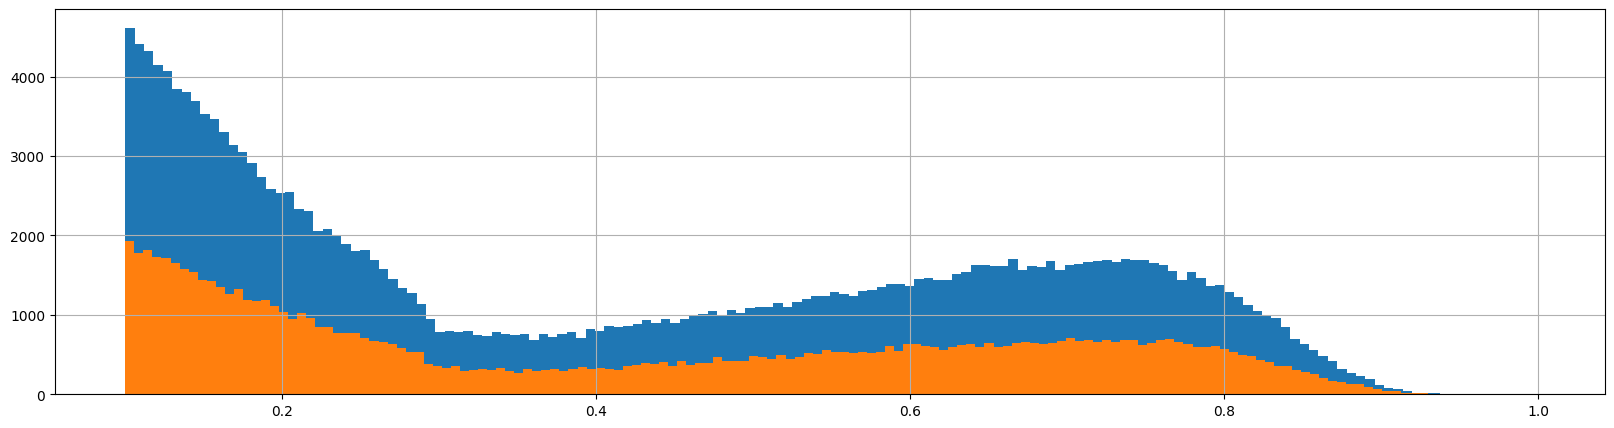

In [4]:
def make_pivot_table(df,  zero_threshold = 0.1, train = True):

    # Переименовываем столбцы, чтоб получить в будущем даты
    renamer = lambda x: x.split('mean_')[-1] if 'nd_mean' in x else x
    df.rename(mapper = renamer, axis=1, inplace=True)

    # Забираем даты
    value_cols = [col for col in df.columns if '2021' in col]
    if train:
        df_melt = df.melt(id_vars = ['id', 'area', 'crop', '.geo'], value_vars = value_cols, value_name = 'NDVI').rename(columns = {'variable':'date'})
    else:
        df_melt = df.melt(id_vars = ['id', 'area'], value_vars = value_cols, value_name = 'NDVI').rename(columns = {'variable':'date'})
    
    df_melt['date'] = pd.to_datetime(df_melt['date'], format='%Y-%m-%d')
    df_melt['day'] = df_melt['date'].dt.dayofyear
    df_melt.sort_values(by = ['id', 'date'], inplace=True)

    # Адаляем нули, это будет пропуски в будущем, заполненые средним ближайших
    drop_zero = lambda x: None if x <= zero_threshold else x 
    df_melt['NDVI'] = df_melt['NDVI'].apply(drop_zero)

    return df_melt
    
train_melt = make_pivot_table(df)    
sub_melt = make_pivot_table(sub, train = False)        

print(train_melt['NDVI'].isnull().sum(), 'Пропуски')
print(train_melt['NDVI'].shape, 'shape')
print(train_melt['id'].nunique(), 'nunique')
train_melt['NDVI'].hist(bins=150, figsize = (20, 5))
sub_melt['NDVI'].hist(bins=150, figsize = (20, 5))

train_melt.head(5)

# Примеры рядов

<AxesSubplot: xlabel='date', ylabel='NDVI'>

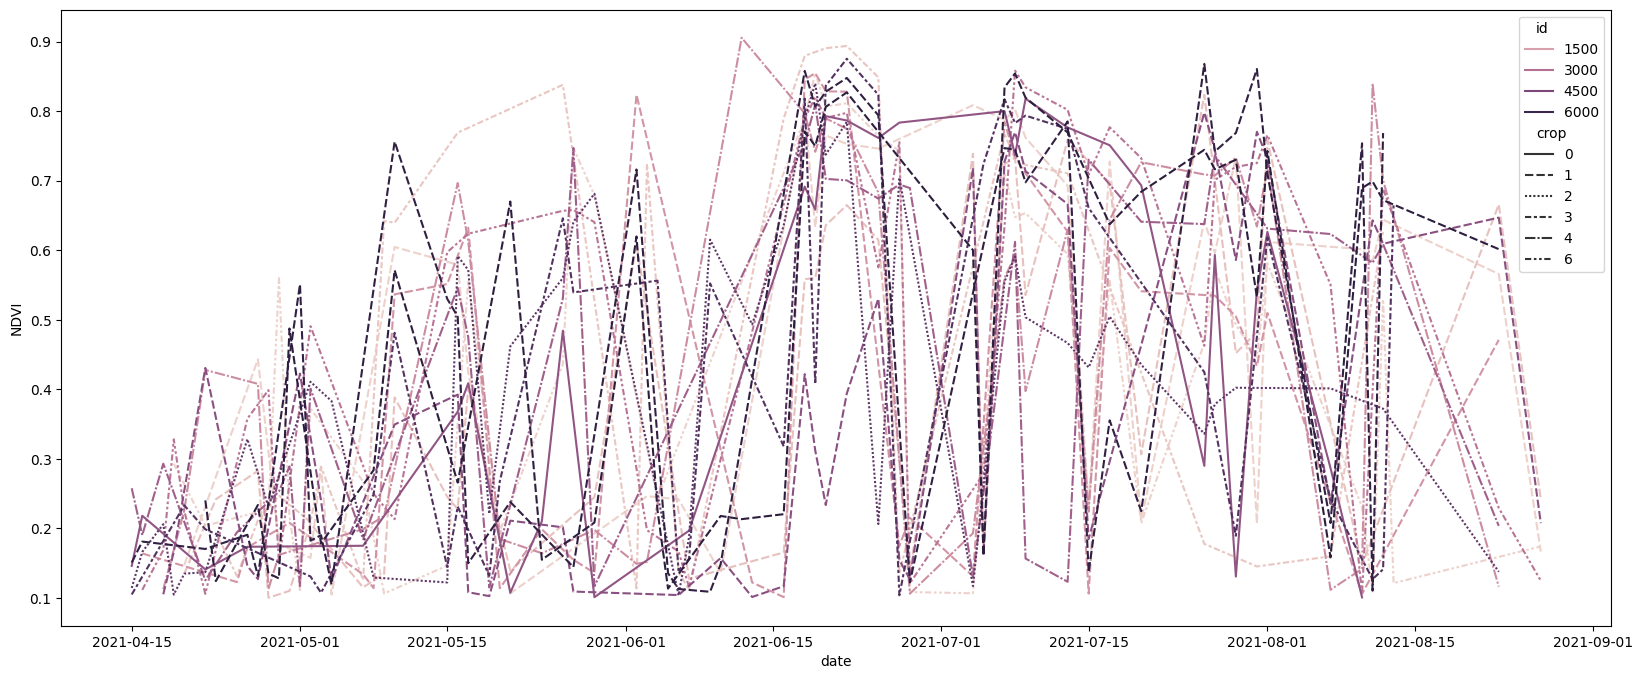

In [5]:
tmp = train_melt[train_melt['id'].isin(np.random.choice(train_melt['id'].unique(), size=15))]

plt.figure(figsize = (20, 8))
sns.lineplot(data = tmp, x='date', y='NDVI', hue='id', style = 'crop')

# Извлекаем координаты центров полей

In [6]:
# https://geopandas.org/en/stable/

import geopandas as gp
from shapely import wkt


def make_geo_coordinates():
    f = pd.read_csv('../../Ivan/Inno/geo_coords.csv')[['id', 'centroid']]

    f['x'] = gp.GeoSeries.from_wkt(f['centroid']).x
    f['y'] = gp.GeoSeries.from_wkt(f['centroid']).y

    f = f[['id', 'x', 'y']]
    # f.head()

    return f

f = make_geo_coordinates()

df = df.merge(f, on = 'id', how = 'left')
sub = sub.merge(f, on = 'id', how = 'left')

# Добавляем процент классов вокруг поля

In [7]:
def make_geo_cell(df):

    df['y_05'] = (df['y'] // 1.5).astype(int)
    df['x_05'] = (df['x'] // 1.5).astype(int)

    df['geo_cell'] = df['y_05'].astype(str) + '_' + df['x_05'].astype(str)
    
    df.drop(['y_05', 'x_05'], axis=1, inplace=True)
    
    
make_geo_cell(df)
make_geo_cell(sub)

df['val'] = 1
cols = ['crop','geo_cell', 'id', 'val']
df_pivot = df[cols].pivot_table(index = 'geo_cell', aggfunc = 'mean', values = 'val', columns = 'crop').fillna(0)
df_pivot.columns = [f'crop_{i}' for i in df_pivot.columns]
df_pivot.reset_index(inplace=True)
df.drop('val', axis=1, inplace=True)
# df_pivot.head()

df = df.merge(df_pivot, on = 'geo_cell', how = 'left')
sub = sub.merge(df_pivot, on = 'geo_cell', how = 'left')

df.head()

,id,area,.geo,2021-04-15,2021-04-16,2021-04-18,2021-04-19,2021-04-20,2021-04-22,2021-04-23,...,x,y,geo_cell,crop_0,crop_1,crop_2,crop_3,crop_4,crop_5,crop_6
0,3536,20,"{""type"":""Polygon"",""coordinates"":[[[42.49107269...",0.187150,0.072846,0.262300,0.261778,0.063134,0.062981,0.000000,...,51.413192,42.500831,28_34,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,3739,45,"{""type"":""Polygon"",""coordinates"":[[[50.25545110...",0.245285,0.332928,0.349133,0.287182,0.064671,0.097138,0.024539,...,56.605879,50.267528,33_37,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1294,28,"{""type"":""Polygon"",""coordinates"":[[[37.99698998...",0.006391,0.013679,0.000000,0.007055,0.000000,0.120804,0.112471,...,53.836396,38.002610,25_35,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2859,19,"{""type"":""Polygon"",""coordinates"":[[[44.72154181...",0.293425,0.105976,0.318047,0.052500,0.153700,0.001917,0.045054,...,55.935386,44.726868,29_37,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,3685,33,"{""type"":""Polygon"",""coordinates"":[[[34.77829934...",0.027983,0.130885,0.117227,0.063492,0.040565,0.024416,0.163886,...,52.907380,34.784405,23_35,1.0,1.0,1.0,1.0,1.0,0.0,1.0


# Добавляем колличество полей вокруг

In [8]:
from parsing_utils import near_feild_fs
    
near_feild_fs(df)
near_feild_fs(sub)

# df

# Классифицируем признаки на группы

In [9]:
fs2drop = ['geo_cell']

drop_features = ['id', '.geo'] + fs2drop
targets = ['crop']  # target_1
cat_features = [] # geo_cell

filtered_features = [i for i in df.columns if (i not in targets and i not in drop_features)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
print('num_features', len(num_features))
print('targets', targets)

for c in cat_features:
    df[c] = df[c].astype(str)

cat_features []
num_features 90
targets ['crop']


# Считаем мат. статистики для каждого поля

In [10]:
from parsing_utils import make_stat_agg

    
df, agg_features = make_stat_agg(df)
sub, _ = make_stat_agg(sub)

date_cols = [col for col in df.columns if '2021-' in col]

# df[agg_features].sample(3)

In [11]:
filtered_features += agg_features
filtered_features = list(np.unique(filtered_features))

# Парсим Гео-мета признаки (Регионы/Районы/Коды)

In [12]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [13]:
# from tqdm.notebook import tqdm
# tqdm.pandas()


## Острожно! Эта ячейка долго парсить данные!
# locator = Nominatim(user_agent=”myGeocoder”)
# df['location'] = df.progress_apply(lambda row: locator.reverse(f'{row.x}, {row.y}').raw, axis=1)
# sub['location'] = sub.progress_apply(lambda row: locator.reverse(f'{row.x}, {row.y}').raw, axis=1)

df = pd.read_csv("../../common_data/Innopolis/train_dataset_livington_v4.csv")
sub = pd.read_csv("../../common_data/Innopolis/test_dataset_livington_v4.csv")

near_feild_fs(df)
near_feild_fs(sub)


In [14]:
adress_features = ["municipality", "municipality_type", "county", "county_type", "state", "state_type",
                   "ISO3166-2-lvl4", "region"]

from parsing_utils import get_county_type, get_state_type, get_municipality_type, get_adress

# get_adress(df)
# get_adress(sub)

df[adress_features].sample(3)

,municipality,municipality_type,county,county_type,state,state_type,ISO3166-2-lvl4,region
3979,1381,2,103,2,5,1,5,1
4488,1469,3,172,2,6,2,6,2
3714,29,2,33,2,3,1,3,1


In [15]:
adress_agg_features = ["state_mean", "region_mean", "mean_state_mean_diff", "mean_region_mean_diff",
                       "municipality_mean", "mean_municipality_mean_diff"]

for adress_feature in ["municipality", "state", "region"]:
    
    val_dict = sub.groupby(adress_feature)["mean"].mean().to_dict()
    df[f"{adress_feature}_mean"] = df[adress_feature].apply(lambda x: val_dict.get(x, 0.))
    df[f"mean_{adress_feature}_mean_diff"] = df[f"{adress_feature}_mean"] - df["mean"]
    sub[f"{adress_feature}_mean"] = sub[adress_feature].apply(lambda x: val_dict.get(x, 0.))
    sub[f"mean_{adress_feature}_mean_diff"] = sub[f"{adress_feature}_mean"] - sub["mean"]

    
    
    
df[adress_agg_features].head(2)

,state_mean,region_mean,mean_state_mean_diff,mean_region_mean_diff,municipality_mean,mean_municipality_mean_diff
0,0.282427,0.267558,0.055412,0.040542,0.256928,0.029912
1,0.260934,0.263769,-0.009658,-0.006823,0.293272,0.022680


In [16]:
from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()

# for adress_feature in adress_features:
#     uniq_values = df[adress_feature].unique()
#     uniq_values = {uniq_values[i]: i+1 for i in range(len(uniq_values))}
#     df[adress_feature] = df[adress_feature].apply(lambda x: uniq_values.get(x, -1))
#     sub[adress_feature] = sub[adress_feature].apply(lambda x: uniq_values.get(x, -1))
    
df[adress_features].head(3)

,municipality,municipality_type,county,county_type,state,state_type,ISO3166-2-lvl4,region
0,1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,2,2
2,3,2,3,2,3,1,3,1


# Извлекаем признаки из библиотеки meteostat 

In [17]:
# https://dev.meteostat.net/python/#example

import meteostat

In [18]:
from parsing_utils import generate_weather_fs

weather_cols = ["tavg", "tmin", "tmax", "prcp", "snow", "wdir", "wspd", "wpgt", "pres", "tsun"]

weather_date_cols = []

for date_col in date_cols:
    for wc in weather_cols:
        weather_date_cols.append(f"{date_col}_{wc}")

# get_weather_info(df)
# get_weather_info(sub)

df[weather_date_cols].sample(2)

,2021-04-15_tavg,2021-04-15_tmin,2021-04-15_tmax,2021-04-15_prcp,2021-04-15_snow,2021-04-15_wdir,2021-04-15_wspd,2021-04-15_wpgt,2021-04-15_pres,2021-04-15_tsun,...,2021-08-27_tavg,2021-08-27_tmin,2021-08-27_tmax,2021-08-27_prcp,2021-08-27_snow,2021-08-27_wdir,2021-08-27_wspd,2021-08-27_wpgt,2021-08-27_pres,2021-08-27_tsun
801,13.9,6.55,18.6,0.0,0.0,142.5,8.55,0.0,1014.4,0.0,...,19.7,16.0,25.7,0.0,0.0,100.0,13.7,0.0,1015.3,0.0
4670,15.4,6.80,23.2,0.0,0.0,112.0,5.10,0.0,1017.8,0.0,...,17.1,12.0,22.6,0.0,0.0,70.0,12.5,0.0,1022.1,0.0


In [19]:
# sub[weather_date_cols].sample(2)

In [20]:
cat_features += adress_features
cat_features = list(np.unique(cat_features))

filtered_features += adress_features + adress_agg_features
filtered_features = list(np.unique(filtered_features))

filtered_features += weather_date_cols
filtered_features = list(np.unique(filtered_features))

cat_features

['ISO3166-2-lvl4',
 'county',
 'county_type',
 'municipality',
 'municipality_type',
 'region',
 'state',
 'state_type']

# Удаляем "плохие" признаки

In [21]:
fs2drop = ['2021-04-29_wspd','2021-07-04_wdir','2021-05-15_wdir','2021-07-09_wdir','2021-05-17_tmin','var','2021-06-13_prcp','2021-07-17_tmax','2021-06-09_tavg','2021-06-09_tmin','2021-05-20_wspd',
           '2021-05-10_wdir', '2021-05-27_tavg','2021-08-07_wspd','2021-07-05_tmax','2021-08-12_pres','2021-06-04_wspd','2021-04-15_wspd','2021-08-27_prcp','2021-05-03_wspd','2021-06-10_tmax',
           '2021-07-17_wspd','2021-05-08_wdir','2021-05-09_pres','2021-08-27_pres','2021-06-22_tmin','2021-06-07_tmin','2021-05-02_wdir','2021-08-23_wdir','2021-08-11_wspd','2021-04-15_tavg',
           '2021-05-24_tmin','2021-07-17_tavg','2021-08-10_wdir','2021-08-13_wspd','2021-04-25_wspd','2021-06-12_tmin','2021-06-02_wspd','2021-07-08_wspd','2021-06-05_tmax','2021-04-27_wspd',
           '2021-07-07_tmax','2021-07-29_wdir','2021-06-05_wspd','2021-04-22_tmin','2021-06-18_wspd','2021-08-07_wdir','2021-07-31_tmax','2021-04-16_wspd','2021-05-07_tmin','2021-06-16_tmin',
           '2021-05-03_prcp','2021-05-19_prcp','2021-05-21_tmin','2021-08-01_wdir','2021-07-27_pres','2021-06-19_tmin','2021-05-15_tmin','2021-05-26_tmax','2021-06-02_tmin','2021-05-02_wspd',
           '2021-04-22_wspd','2021-05-21_wdir','2021-07-17_tmin','2021-06-03_wdir','2021-06-19_tmax','2021-08-01_tavg','2021-04-19_tmin','2021-05-16_pres','2021-08-12_wdir','2021-04-20_prcp',
           '2021-08-12_wspd','2021-04-26_wspd','2021-07-13_wspd','2021-08-01_tmin','2021-06-12_tmax','2021-04-16_tmax','2021-07-15_tmin','2021-07-20_wdir','2021-07-09_tmax','2021-06-25_wdir',
           '2021-04-28_tavg','2021-06-19_tavg','2021-04-28_wspd','2021-06-10_tmin','2021-06-25_wspd','2021-04-23_tmin','2021-06-06_wspd','2021-05-08_tmin','2021-08-12_tmax','2021-05-02_tmin',
           '2021-07-26_tmax','month_argmin','2021-08-13_tmax','2021-04-23_tmax', '2021-05-20_tavg','2021-04-20_tmax','2021-04-16_wdir','2021-04-15_wdir','2021-05-07_tmax'
          ]

print(len(fs2drop))

fs2drop +=  ['2021-06-16_snow','2021-06-18_tsun','2021-06-18_snow','2021-05-15_tsun','2021-06-16_wpgt','2021-05-15_wpgt','2021-06-16_tsun','2021-04-23_tsun','2021-06-12_tsun','2021-06-13_wpgt',
           '2021-05-16_snow','2021-06-13_tsun','2021-06-13_snow','2021-05-16_tsun','2021-06-12_wpgt','2021-05-19_snow','2021-06-06_snow','2021-04-20_snow','2021-05-27_snow','2021-04-26_wpgt',
           '2021-05-29_tsun','2021-05-29_snow','2021-05-21_snow','2021-05-27_wpgt','2021-05-27_tsun','2021-05-26_wpgt','2021-04-26_snow','2021-05-21_tsun','2021-05-26_tsun','2021-05-26_snow',
           '2021-04-26_tsun','2021-05-24_wpgt','2021-05-24_tsun','2021-05-29_wpgt','2021-06-02_snow','2021-05-19_wpgt','2021-06-04_snow','2021-06-05_wpgt','2021-06-05_tsun','2021-06-05_snow',
           '2021-06-04_wpgt','2021-06-04_tsun','2021-05-20_snow','2021-04-25_tsun','2021-06-02_tsun','2021-06-03_wpgt','2021-06-03_tsun','2021-04-25_wpgt','2021-05-20_tsun','2021-06-03_snow',
           '2021-06-02_wpgt','2021-06-18_wpgt','2021-04-23_snow','2021-05-15_snow','2021-07-09_tsun','2021-05-07_wpgt','2021-07-13_tsun','2021-04-27_wpgt','2021-07-13_snow','2021-04-20_wpgt',
           '2021-07-09_wpgt','2021-07-09_snow','2021-05-07_tsun','2021-07-09_prcp','2021-07-08_wpgt','2021-05-08_snow','2021-07-08_tsun','2021-05-08_tsun','2021-07-08_snow','2021-07-13_wpgt',
           '2021-07-15_snow','2021-06-19_snow','2021-05-04_wpgt','2021-07-26_wpgt','2021-07-26_tsun','2021-07-26_snow','2021-05-04_tsun','2021-07-20_wpgt','2021-07-20_tsun','2021-07-20_snow',
           '2021-07-15_tsun','2021-07-17_wpgt','2021-07-17_tsun','2021-07-17_snow','2021-04-20_tsun','2021-05-07_snow','2021-07-15_wpgt','2021-05-08_wpgt','2021-07-07_wpgt','2021-07-07_tsun',
           '2021-06-22_snow','2021-04-22_tsun','2021-06-25_wpgt','2021-06-25_tsun','2021-06-25_snow','2021-05-10_tsun','2021-06-22_tsun','2021-05-10_wpgt','2021-07-07_snow','2021-06-22_prcp',
           '2021-04-22_wpgt','2021-06-20_tsun','2021-06-20_snow','2021-06-19_wpgt','2021-06-19_tsun','2021-06-27_snow','2021-05-10_snow','2021-06-27_tsun','2021-06-27_wpgt','2021-04-27_tsun',
           '2021-06-28_snow','2021-05-09_wpgt','2021-06-28_tsun','2021-05-09_tsun','2021-07-04_snow','2021-07-04_tsun','2021-04-22_snow','2021-07-05_snow','2021-07-05_tsun','2021-07-05_wpgt',
           '2021-05-09_snow','2021-07-07_prcp','2021-04-28_wpgt']

print(len(fs2drop))

################################################################ 0.981291 ############################################################     

filtered_features = [c for c in filtered_features if c not in fs2drop]
cat_features = [c for c in cat_features if c not in fs2drop]
filtered_features = [col for col in filtered_features if col in df.columns] 

len(filtered_features)

100
223


600

# LightGMB Model

In [22]:
# https://lightgbm.readthedocs.io/en/latest/Features.html

from lightgbm import LGBMClassifier #,LGBMRegressor

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold # k-фолдная валидация
from lightgbm import LGBMClassifier #,LGBMRegressor
from lightgbm import Dataset, train

import gc 

random_state = 42
n_splits = 10 # kfolds
print('num folds', n_splits)
clfs = []
targets = ['crop']

n_estimators = [400, 300, 400, 300, 400, 300, 300, 300, 400, 500] # best!!

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

X = df[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
y = df[targets]#.copy()

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Dataset(data = X_train, label = y_train, categorical_feature=cat_features)
    eval_dataset = Dataset(data = X_test, label = y_test, categorical_feature=cat_features)

    print(f'fold {i}', X_train.shape, y_train.shape)

    lgb_params = {
         'learning_rate' : 0.1*0.9, 'n_estimators' : n_estimators[i] + 100, 
        'objective': 'multiclass', 'num_class' : 7, 

        'uniform_drop' : True,  'boosting': 'dart',   # goss 
        'lambda_l2' : 1/100, 'feature_fraction': 0.53, # 0.55
        'bagging_freq': 125, 'min_split_gain': 1/1000,

        'max_bin' : 260,
        'random_seed' : 42, 'drop_seed' : 7575,
        'verbose': -1,
    }


    clf = train(params = lgb_params, train_set = train_dataset,
               verbose_eval = 100, valid_sets=eval_dataset)
    clfs.append(clf)

        

num folds 10
fold 0 (4347, 600) (4347, 1)


[100]	valid_0's multi_logloss: 0.14115	valid_0's _recall_score: 0.977323
[200]	valid_0's multi_logloss: 0.0719376	valid_0's _recall_score: 0.979207
[300]	valid_0's multi_logloss: 0.0502589	valid_0's _recall_score: 0.977378
[400]	valid_0's multi_logloss: 0.0485741	valid_0's _recall_score: 0.980153
[500]	valid_0's multi_logloss: 0.0475584	valid_0's _recall_score: 0.9794
fold 1 (4347, 600) (4347, 1)


[100]	valid_0's multi_logloss: 0.150039	valid_0's _recall_score: 0.970989
[200]	valid_0's multi_logloss: 0.0882678	valid_0's _recall_score: 0.972583
[300]	valid_0's multi_logloss: 0.075985	valid_0's _recall_score: 0.972583
[400]	valid_0's multi_logloss: 0.0798743	valid_0's _recall_score: 0.977954
fold 2 (4347, 600) (4347, 1)


[100]	valid_0's multi_logloss: 0.131414	valid_0's _recall_score: 0.979162
[200]	valid_0's multi_logloss: 0.0649101	valid_0's _recall_score: 0.979289
[300]	valid_0's multi_logloss: 0.0450205	valid_0's _recall_score: 0.981577
[400]	valid_0's multi_logloss: 0.0433381	valid_0's _recall_score: 0.979608
[500]	valid_0's multi_logloss: 0.0445505	valid_0's _recall_score: 0.981577
fold 3 (4347, 600) (4347, 1)


[100]	valid_0's multi_logloss: 0.164615	valid_0's _recall_score: 0.97391
[200]	valid_0's multi_logloss: 0.107614	valid_0's _recall_score: 0.972454
[300]	valid_0's multi_logloss: 0.105535	valid_0's _recall_score: 0.97396
[400]	valid_0's multi_logloss: 0.115599	valid_0's _recall_score: 0.97396
fold 4 (4347, 600) (4347, 1)


[100]	valid_0's multi_logloss: 0.145331	valid_0's _recall_score: 0.974505
[200]	valid_0's multi_logloss: 0.0799028	valid_0's _recall_score: 0.98022


# Готовим финальный сабмит

In [ ]:
# массив для записи финального результата
y_pred = np.zeros((sub.shape[0], 7))
scores = {'multi_logloss':[], 'Precision' : [], 'Recall' : []}
for n, clf in enumerate(clfs):
    y_pred += clf.predict(sub[filtered_features])#[:,1]
    scores['multi_logloss'].append(clf.best_score['valid_0']['multi_logloss'])
    scores['Recall'].append(clf.best_score['valid_0']['_recall_score'])

y_pred /= N
print('mean multi_logloss', np.mean(scores['multi_logloss'], dtype = 'float32'), f'По {len(clfs)} моделям')
print('mean Recall', np.mean(scores['Recall'], dtype = 'float32'), f'По {len(clfs)} моделям')


sample_solution = pd.read_csv('../../common_data/Innopolis/sample_solution.csv')
sample_solution['crop'] = np.argmax(y_pred, axis=1)

sub_num = '18'
sample_solution.to_csv(f'./subs/dart_20_livington_sub_{sub_num}.csv', index=False)

In [ ]:
# mean multi_logloss 0.07110747 По 10 моделям
# mean Recall 0.9774499 По 10 моделям core = 0.979661

# mean multi_logloss 0.070384085 По 10 моделям
# mean Recall 0.97922766 По 10 моделям = 0.980354

# mean multi_logloss 0.07117752 По 10 моделям
# mean Recall 0.9782778 По 10 моделям = 0.980257  

# mean multi_logloss 0.07088373 По 10 моделям
# mean Recall 0.97875816 По 10 моделям = 0.982301 best!!!

# mean multi_logloss 0.06909923 По 10 моделям
# mean Recall 0.9790772 По 10 моделям = 0.981185

# mean multi_logloss 0.07072832 По 10 моделям
# mean Recall 0.978789 По 10 моделям = 0.981185


In [ ]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), 'Усреднее по {}-ти моделям: '.format(len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].median().sort_values(by='importance', ascending=False)


df_feats_imp = plot_importance(df[filtered_features], clfs, height = 0.20, top_n = 70)